In [115]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
# from torchvision.transforms import 


In [8]:
batch_size = 12

#### Dataset

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((50,50)),
    transforms.Lambda(lambda t : (t*2)-1)
    ])

In [17]:
training_data = datasets.Flowers102(
    root="data",
    split='train',
    download=True,
    transform=transform
)
validation_data = datasets.Flowers102(
    root="data",
    split='val',
    download=True,
    transform=transform
)

test_data =  datasets.Flowers102(
    root="data",
    split='test',
    download=True,
    transform=transform
)

In [18]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [100]:
def show_image(img):
    # print("Shape of img [C, H, W]: ", img.shape)
    reverse_transform = transforms.Compose([
        transforms.Lambda(lambda t : (t+1)/2),
        transforms.Lambda(lambda t : t.permute(1,2,0)), # Convert from CHW to HWC
        transforms.Lambda(lambda t : t*255.),
        transforms.Lambda(lambda t : t.numpy().astype(np.uint8)),
        transforms.ToPILImage()
        ])
    # print("After transform: Shape of img [C, H, W]: ", reverse_transform(img).shape)
    plt.imshow(reverse_transform(img))

In [101]:
loader_iter =iter(test_dataloader)

Shape of X [N, C, H, W]:  torch.Size([12, 3, 50, 50])


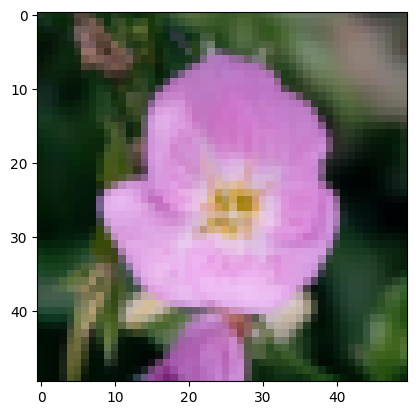

In [102]:
for X in next(loader_iter):
    print("Shape of X [N, C, H, W]: ", X.shape) 
    show_image(X[0])
    break

#### Formward diff

In [111]:
# Noise Scheduler
def noise_scheduler(timesteps, beta_start=0.0001, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

def get_value_at_timestep(values, t, x0_shape):
    batch_size = t.shape[0]
    values_at_t = values.gather(-1,t) 
    values = values_at_t.reshape(batch_size,*(-1)*x0_shape) 
    return values

# Forward diffusion
def forward_diffusion(x0, t):
    noise = torch.randn_like(x0)
    sqrt_alphas_cumprod_t = get_value_at_timestep(sqrt_alphas_cumprod, t, x0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_value_at_timestep(
        sqrt_one_minus_alphas_cumprod, t, x0.shape
    ) 
    diffused_image = sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * noise
    return diffused_image
    
# Pre calucalte values for forward diffusion
T = 100
betas = noise_scheduler(T)
# print(betas)
alphas = 1 - betas
# print(alphas)
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = torch.cat([torch.ones(1),alphas_cumprod[:-1]],dim=0) # [1.0] +alphas_cumprod[:-1]
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [112]:
test_image = next(iter(train_dataloader))[0][0] # first img in first batch of train_dataloader

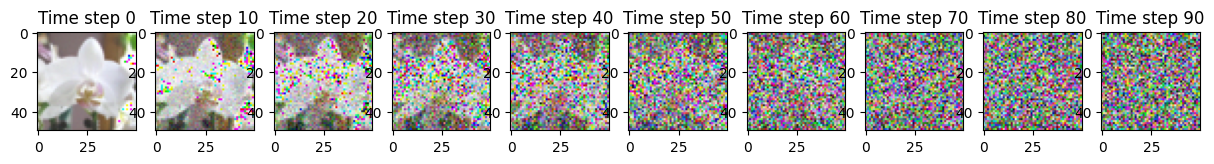

In [114]:
step_size = T//10
plt.figure(figsize=(15,15))
num_images = 10 # T/step_size
for i in range(0,T,step_size):
    t = torch.tensor([i])
    # print(t.shape)
    # print(t)
    diffused_image = forward_diffusion(test_image, t)
    plt.subplot(1, num_images, int(i/step_size) + 1)
    plt.title(f'Time step {i}', fontsize=12)
    show_image(diffused_image)

#### Reverse 

##### U-net block

In [142]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        print('Channels:',in_channels, out_channels)    
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        return self.activation(self.conv2(self.activation(self.conv1(x))))

In [143]:
block = Block(3, 64)
x = torch.randn(3,64,64)
block(x).shape

Channels: 3 64


torch.Size([64, 64, 64])

##### Encoder

In [144]:
class Encoder(nn.Module):
    def __init__(self, channels = [3, 64, 128, 256, 512, 1024]):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(channels[i], channels[i+1])  
                                         for i in range(len(channels)-1)
                                         ])
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        features = []
        for block in self.enc_blocks:
            x = block(x)
            features.append(x)
            x = self.maxpool(x)
            print(x.shape)
        return features

In [145]:
encoder = Encoder()

Channels: 3 64
Channels: 64 128
Channels: 128 256
Channels: 256 512
Channels: 512 1024


In [147]:
residuals = encoder(x)

torch.Size([64, 32, 32])
torch.Size([128, 16, 16])
torch.Size([256, 8, 8])
torch.Size([512, 4, 4])
torch.Size([1024, 2, 2])


In [150]:
print(residuals)

[tensor([[[0.0000, 0.0466, 0.0000,  ..., 0.0000, 0.0000, 0.1521],
         [0.0000, 0.0000, 0.0000,  ..., 0.2577, 0.0000, 0.2301],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2521, 0.3073],
         ...,
         [0.0000, 0.1589, 0.0000,  ..., 0.0000, 0.1063, 0.2447],
         [0.0000, 0.0760, 0.1806,  ..., 0.1377, 0.1800, 0.2678],
         [0.0426, 0.0000, 0.2396,  ..., 0.0000, 0.0117, 0.0390]],

        [[0.2137, 0.2507, 0.2190,  ..., 0.3747, 0.0978, 0.3262],
         [0.0097, 0.2915, 0.0000,  ..., 0.3665, 0.5620, 0.3114],
         [0.3346, 0.5358, 0.5428,  ..., 0.4286, 0.6065, 0.2412],
         ...,
         [0.0975, 0.2704, 0.4224,  ..., 0.6036, 0.2452, 0.2695],
         [0.4295, 0.2113, 0.6702,  ..., 0.1974, 0.2530, 0.2167],
         [0.0613, 0.0708, 0.1003,  ..., 0.1141, 0.3288, 0.2287]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0635,  ..., 0.0658, 0.0000, 0.0105],
         [0.3506, 0.0000, 0.0393,  ..., 0.0000, 0.2628, 0

##### Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, channels = [1024, 512, 256, 128, 64]):
        super().__init__()
    
    def forward(self, x):
        